# Pipeline for Query Expansion Model BART

## Natural Language Processing
### Group Members:  
*Group Member 1:* Saadat Hussain  
*Group Member 2:* Muhammad Bilal Tahir

In [1]:
pip install datasets transformers torch

Note: you may need to restart the kernel to use updated packages.


#### Loading Dataset

In [35]:
from datasets import load_dataset

# Load the dataset
ds_large = load_dataset("Isotonic/query_understanding_extended")

# Retain 20% of the original dataset
ds_small = ds['train'].train_test_split(test_size=0.2, seed=42)['test']

# Further split the 20% dataset into train and test (e.g., 80%-20% split)
ds = ds_small.train_test_split(test_size=0.2, seed=42)


# Check the new splits
print(ds)


DatasetDict({
    train: Dataset({
        features: ['instruction', 'intent', 'knowledge', 'difficulty', 'quality_explanation', 'task_category', 'other_task_category', '__index_level_0__'],
        num_rows: 17217
    })
    test: Dataset({
        features: ['instruction', 'intent', 'knowledge', 'difficulty', 'quality_explanation', 'task_category', 'other_task_category', '__index_level_0__'],
        num_rows: 4305
    })
})


In [36]:
# Explore the first few entries in the training set
print(ds['train'][0])

{'instruction': 'Response: Would a report proposing the establishment of new offshore marine protected areas be well-received by the Department of the Navy? Remove any references to abortion from the introductory statement and address concerns regarding national defense and operations. Also, revise to avoid suggesting major tank vessel transits.', 'intent': 'The user wants to analyze the feasibility of a report proposing the establishment of new offshore marine protected areas and suggest revisions to make it more acceptable to the Department of the Navy, while considering national defense and operations.', 'knowledge': "To solve this problem, I need to know about the Department of the Navy's policies and concerns regarding national defense and operations, as well as the process of proposing and establishing marine protected areas.", 'difficulty': 'medium', 'quality_explanation': "The query is well-structured and specific, with a clear request for a report proposal and specific require

In [37]:
# Check dataset structure
print("Dataset splits:", ds)

# Check the first few examples in the training set
print("First example in the training set:", ds['train'][0])

# Check the size of each split
print("Size of training set:", len(ds['train']))

Dataset splits: DatasetDict({
    train: Dataset({
        features: ['instruction', 'intent', 'knowledge', 'difficulty', 'quality_explanation', 'task_category', 'other_task_category', '__index_level_0__'],
        num_rows: 17217
    })
    test: Dataset({
        features: ['instruction', 'intent', 'knowledge', 'difficulty', 'quality_explanation', 'task_category', 'other_task_category', '__index_level_0__'],
        num_rows: 4305
    })
})
First example in the training set: {'instruction': 'Response: Would a report proposing the establishment of new offshore marine protected areas be well-received by the Department of the Navy? Remove any references to abortion from the introductory statement and address concerns regarding national defense and operations. Also, revise to avoid suggesting major tank vessel transits.', 'intent': 'The user wants to analyze the feasibility of a report proposing the establishment of new offshore marine protected areas and suggest revisions to make it mor

In [38]:
import random

# Show a few random samples from the dataset
num_samples = 5
for _ in range(num_samples):
    random_index = random.randint(0, len(ds['train']) - 1)
    print(ds['train'][random_index])
    print("-" * 50)


{'instruction': 'Plot the Cantor set.', 'intent': 'The user wants to visualize a mathematical concept, specifically the Cantor set.', 'knowledge': 'To solve this problem, I need to know basic concepts of set theory and mathematical visualization.', 'difficulty': 'easy', 'quality_explanation': 'The query is very specific and concise, asking for a plot of the Cantor set. However, it lacks context and does not specify what kind of plot is desired (e.g., graphical, mathematical, etc.).', 'task_category': 'Math', 'other_task_category': ['Information seeking'], '__index_level_0__': 104950}
--------------------------------------------------
{'instruction': 'If my room is 150 meters square and wood costs 14 yuan per meter square, how much money can I save if I buy wood at 28 yuan per square meter instead of 42 yuan? Your answer should be in Yuan.', 'intent': 'The user wants to calculate the cost of wood and find the amount of money that can be saved by buying wood at a lower price.', 'knowledg

In [39]:
# Check the available splits in the dataset
print(ds.keys())


dict_keys(['train', 'test'])


In [40]:
# Check keys of the first entry in the training set
print(ds['train'][0])

{'instruction': 'Response: Would a report proposing the establishment of new offshore marine protected areas be well-received by the Department of the Navy? Remove any references to abortion from the introductory statement and address concerns regarding national defense and operations. Also, revise to avoid suggesting major tank vessel transits.', 'intent': 'The user wants to analyze the feasibility of a report proposing the establishment of new offshore marine protected areas and suggest revisions to make it more acceptable to the Department of the Navy, while considering national defense and operations.', 'knowledge': "To solve this problem, I need to know about the Department of the Navy's policies and concerns regarding national defense and operations, as well as the process of proposing and establishing marine protected areas.", 'difficulty': 'medium', 'quality_explanation': "The query is well-structured and specific, with a clear request for a report proposal and specific require

In [41]:
# Display all keys in one sample
print("Keys in the dataset entry:", ds['train'][0].keys())

# Display the first example for each key
for key, value in ds['train'][0].items():
    print(f"{key}: {value}")


Keys in the dataset entry: dict_keys(['instruction', 'intent', 'knowledge', 'difficulty', 'quality_explanation', 'task_category', 'other_task_category', '__index_level_0__'])
instruction: Response: Would a report proposing the establishment of new offshore marine protected areas be well-received by the Department of the Navy? Remove any references to abortion from the introductory statement and address concerns regarding national defense and operations. Also, revise to avoid suggesting major tank vessel transits.
intent: The user wants to analyze the feasibility of a report proposing the establishment of new offshore marine protected areas and suggest revisions to make it more acceptable to the Department of the Navy, while considering national defense and operations.
knowledge: To solve this problem, I need to know about the Department of the Navy's policies and concerns regarding national defense and operations, as well as the process of proposing and establishing marine protected ar

In [42]:
from collections import Counter

# Count occurrences of each difficulty level
difficulty_counts = Counter([example['difficulty'] for example in ds['train']])
print("Difficulty distribution:", difficulty_counts)



Difficulty distribution: Counter({'medium': 14014, 'hard': 2262, 'easy': 873, 'very hard': 62, 'very easy': 6})


In [43]:
from collections import Counter

# Safely count occurrences of each task category
task_categories = [
    category
    for example in ds['train']
    if example['other_task_category'] is not None  # Check for None
    for category in example['other_task_category']
]

task_category_counts = Counter(task_categories)
print("Task category distribution:", task_category_counts)


Task category distribution: Counter({'Information seeking': 7172, 'Reasoning': 6253, 'Data analysis': 5074, 'Advice seeking': 4082, 'Math': 2032, 'Planning': 1640, 'Editing': 1306, 'Brainstorming': 1166, 'Creative writing': 1046, 'Others': 949, 'Coding & Debugging': 795, 'Role playing': 489, 'Problem Solving': 106, 'Problem-solving': 68, 'Design': 35, 'Troubleshooting': 24, 'Philosophy': 22, 'Error handling': 21, 'Problem solving': 19, 'Error Handling': 15, 'None': 13, 'Description': 13, 'Ethics': 11, 'History': 11, 'Communication': 9, 'Emotional support': 9, 'Emotional Support': 8, 'Security': 8, 'Testing': 6, 'none': 5, 'Data visualization': 5, 'Storytelling': 5, 'Humor': 5, 'Machine learning': 4, 'Health': 4, 'Explanation': 4, 'Machine Learning': 4, 'Data processing': 3, 'Game Development': 3, 'Description writing': 3, 'Relationship': 3, 'Natural Language Processing': 3, 'CSS': 3, 'Education': 3, 'Personal growth': 3, 'Literary analysis': 3, 'UI/UX': 3, 'Relationships': 2, 'Data man

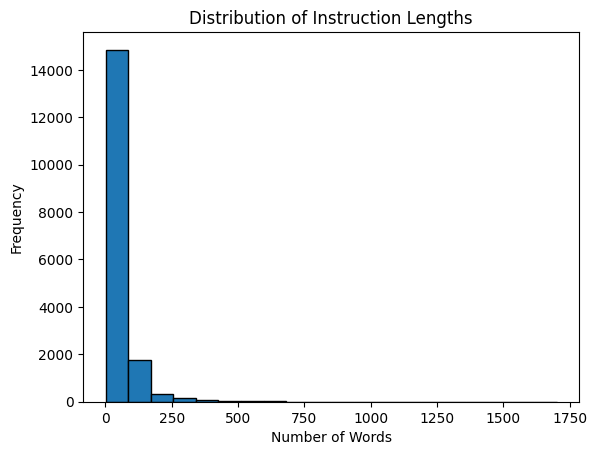

In [44]:
# Check lengths of instructions
instruction_lengths = [len(example['instruction'].split()) for example in ds['train']]

# Plot distribution of instruction lengths
import matplotlib.pyplot as plt
plt.hist(instruction_lengths, bins=20, edgecolor="black")
plt.title("Distribution of Instruction Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


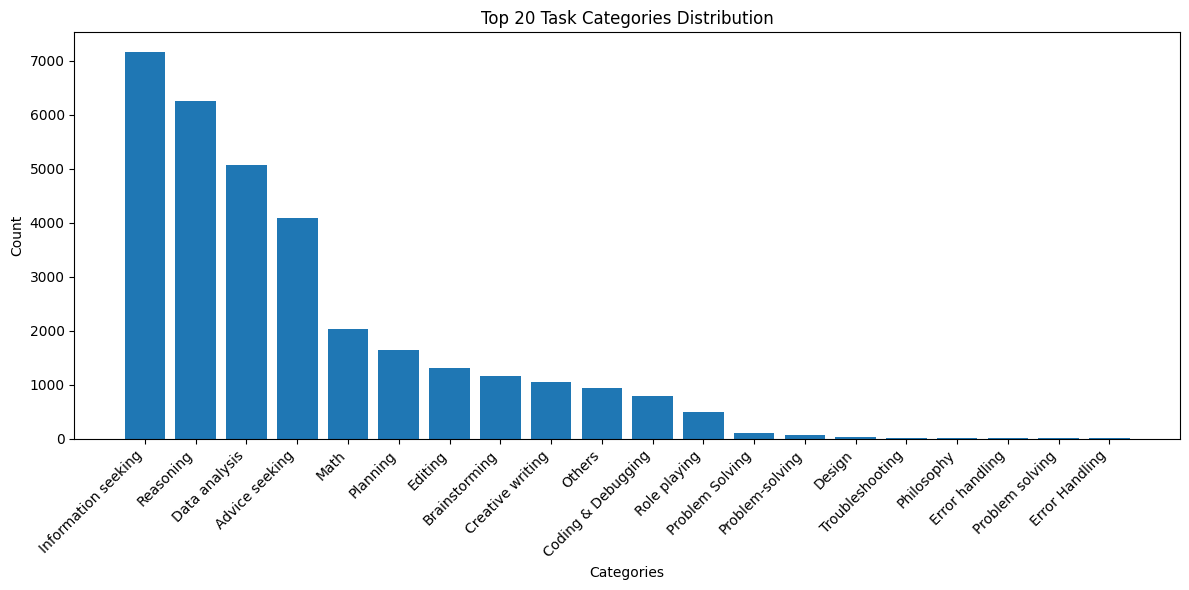

In [45]:
import matplotlib.pyplot as plt

# Select top 20 categories for visualization
top_20_categories = task_category_counts.most_common(20)
categories, counts = zip(*top_20_categories)

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(categories, counts)
plt.title("Top 20 Task Categories Distribution")
plt.xlabel("Categories")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [46]:
# Count instances with missing categories
missing_categories = sum(1 for example in ds['train'] if example['other_task_category'] is None)
print(f"Number of entries with missing categories: {missing_categories}")


Number of entries with missing categories: 0


In [47]:

# Check for missing values
print("Missing intent:", sum(1 for example in ds['train'] if not example['intent']))
print("Missing knowledge:", sum(1 for example in ds['train'] if not example['knowledge']))

# Filter out rows with missing target fields (if any)
ds = ds.filter(lambda x: x['intent'] is not None and x['knowledge'] is not None)


Missing intent: 0
Missing knowledge: 0


In [51]:
from transformers import BartForConditionalGeneration, BartTokenizer
import torch
from torch.utils.data import DataLoader


# Split the 'train' dataset into train and test subsets
train_test_split = ds['train'].train_test_split(test_size=0.2, seed=42)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

# Load BART tokenizer and model
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-base").to("cuda" if torch.cuda.is_available() else "cpu")


In [52]:
# Filter out invalid examples (where instruction or intent is None)
train_dataset = train_dataset.filter(lambda x: isinstance(x['instruction'], str) and isinstance(x['intent'], str))
test_dataset = test_dataset.filter(lambda x: isinstance(x['instruction'], str) and isinstance(x['intent'], str))

Filter:   0%|          | 0/13773 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3444 [00:00<?, ? examples/s]

In [53]:
# Tokenization function
def tokenize_function(examples):
    # Combine the instruction input for all examples in the batch
    inputs = ["expand: " + instruction for instruction in examples['instruction']]
    targets = examples['intent']

    # Tokenize inputs and targets
    model_inputs = tokenizer(inputs, max_length=128, padding="max_length", truncation=True)
    labels = tokenizer(targets, max_length=128, padding="max_length", truncation=True)

    # Add labels to inputs
    model_inputs['labels'] = labels['input_ids']
    return model_inputs

# Tokenize datasets
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/13773 [00:00<?, ? examples/s]

Map:   0%|          | 0/3444 [00:00<?, ? examples/s]

In [56]:
class QueryExpansionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings['input_ids'])

# Convert tokenized data into PyTorch datasets
train_data = QueryExpansionDataset({key: tokenized_train[key] for key in ['input_ids', 'attention_mask', 'labels']})
test_data = QueryExpansionDataset({key: tokenized_test[key] for key in ['input_ids', 'attention_mask', 'labels']})

# DataLoaders
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
test_loader = DataLoader(test_data, batch_size=8)


In [57]:
from transformers import AdamW
from tqdm import tqdm

# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(3):  # Training for 3 epochs
    model.train()
    loop = tqdm(train_loader, leave=True)
    total_loss = 0

    for batch in loop:
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}

        # Forward pass
        outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], labels=batch['labels'])
        loss = outputs.loss

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update progress bar
        total_loss += loss.item()
        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1} finished. Total Loss: {total_loss / len(train_loader)}")

Epoch 1: 100%|██████████| 1722/1722 [10:05<00:00,  2.84it/s, loss=0.178] 


Epoch 1 finished. Total Loss: 0.22835946883292357


Epoch 2: 100%|██████████| 1722/1722 [10:05<00:00,  2.84it/s, loss=0.336] 


Epoch 2 finished. Total Loss: 0.17362506098344352


Epoch 3: 100%|██████████| 1722/1722 [10:05<00:00,  2.84it/s, loss=0.09]  

Epoch 3 finished. Total Loss: 0.13843836476128552


In [58]:
model.eval()
predictions, references = [], []

with torch.no_grad():
    for batch in tqdm(test_loader):
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}

        # Generate predictions
        outputs = model.generate(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], max_length=128)
        preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        # Decode references
        refs = tokenizer.batch_decode(batch['labels'], skip_special_tokens=True)

        predictions.extend(preds)
        references.extend(refs)

# Print some examples
for i in range(5):
    print(f"Input: {tokenized_test[i]['instruction']}")
    print(f"Reference: {references[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 50)


100%|██████████| 431/431 [04:53<00:00,  1.47it/s]

Input: The equation $y = -16t^2 + 60t$ describes the height (in feet) of a projectile launched from the ground at 60 feet per second upward. In how many seconds will the projectile first reach 56 feet in height? Express your answer as a decimal rounded to the nearest hundredth.
Reference: The user wants to find the time when a projectile launched from the ground at 60 feet per second upward will first reach a height of 56 feet.
Prediction: The user wants to calculate the time it takes for a projectile to reach a certain height.
--------------------------------------------------
Input: Wise Warrior V uses Featureful Backbone for a string like capital "W". To use as little horizontal cells as possible, focus on the width of capital "W" provided that the vertical parts have 1 cell and the minimum crossbar sits at a height of 3 ridges. Let's also assume the character is "Winsome". Specify parameters for the string including ridges.
Reference: The user wants to optimize the layout of the st

In [74]:
model.save_pretrained("/kaggle/working/bart_query_expansion")
tokenizer.save_pretrained("/kaggle/working/bart_query_expansion")


('/kaggle/working/bart_query_expansion/tokenizer_config.json',
 '/kaggle/working/bart_query_expansion/special_tokens_map.json',
 '/kaggle/working/bart_query_expansion/vocab.json',
 '/kaggle/working/bart_query_expansion/merges.txt',
 '/kaggle/working/bart_query_expansion/added_tokens.json')

'/kaggle/working/bart_query_expansion.zip'